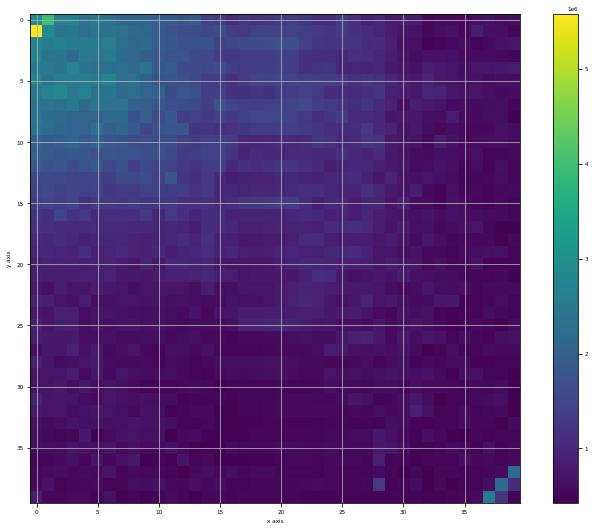

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from lmfit.models import QuadraticModel, LorentzianModel
import math

def findarg(data, value):
    arg = 0
    for wl in data:
        if wl<value:
            arg = arg + 1
        else:
            return arg
        
    return arg


data = pd.read_pickle('asher_20230603_hyperspec_EL2_97.pkl')

im = data['im']
wavel = data['wavelength']
map = np.sum(im, axis = 2)
# pixel numbers x and y
px = len(im)
py = len(im[0])
intensity = np.zeros((px,py))
#total intensity plot
plt.figure(figsize=(12,9))
plt.grid()
plt.imshow(map, cmap='viridis')
plt.colorbar()
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()

# Check Full PL

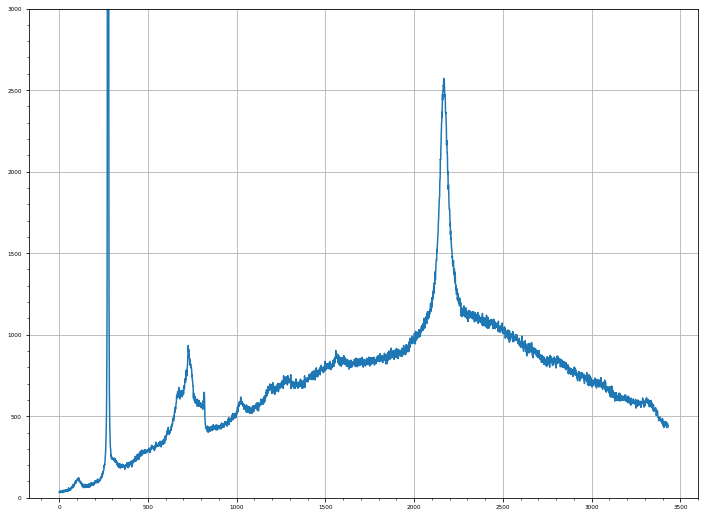

In [55]:
regionx, regiony = 0,2
# regionx, regiony = 0,0
# regionx, regiony = 36,13
plt.figure(figsize=(12,9))
plt.grid()
plt.minorticks_on()
plt.ylim(0,3000)
plt.plot(data['im'][regionx][regiony])

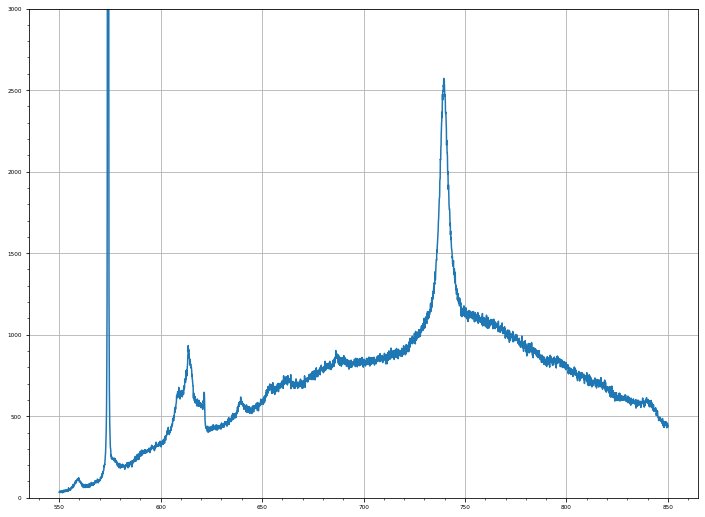

In [56]:
plt.figure(figsize=(12,9))
plt.grid()
plt.minorticks_on()
plt.ylim(0,3000)
plt.plot(wavel,data['im'][regionx][regiony])

# Check NV- PL

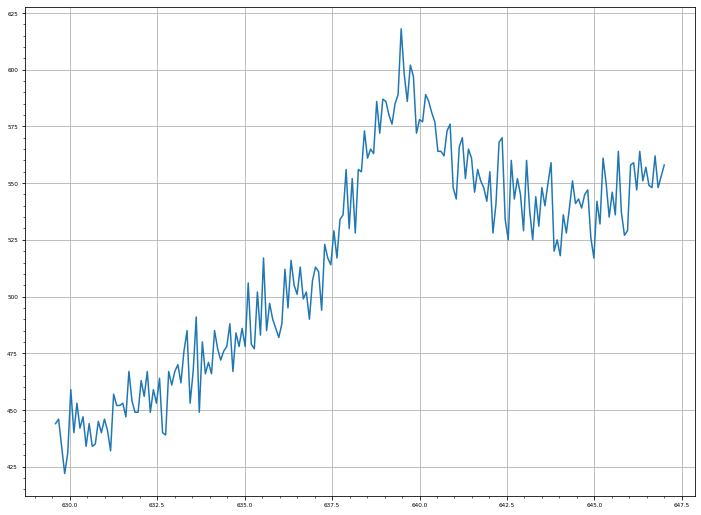

In [57]:
plt.figure(figsize=(12,9))
plt.grid()
plt.minorticks_on()
plt.plot(wavel[910:1110],data['im'][regionx][regiony][910:1110])

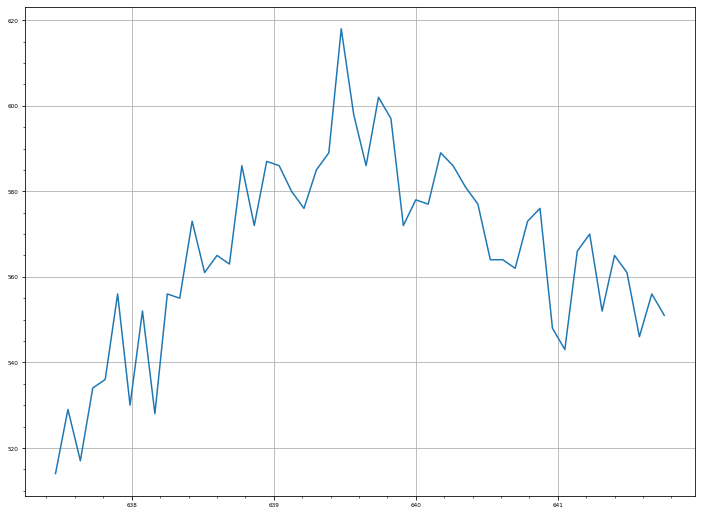

In [58]:
plt.figure(figsize=(12,9))
plt.grid()
plt.minorticks_on()
plt.plot(data['wavelength'][1000:1050],data['im'][regionx][regiony][1000:1050])

# Fit NV-

In [59]:
currentPL = data['im'][regionx][regiony]
model2 = QuadraticModel(prefix='bkg_') + LorentzianModel(prefix='nvm_')
model = model2
params = model.make_params()
print('parameter names: {}'.format(model.param_names))

parameter names: ['bkg_a', 'bkg_b', 'bkg_c', 'nvm_amplitude', 'nvm_center', 'nvm_sigma']


In [60]:
params['nvm_center'].set(value=639, min = 638, max = 640, vary=True)
params['nvm_amplitude'].set(value=1000, vary=True)
params['nvm_sigma'].set(value=2, max = 5, vary=True)

params['bkg_a'].set(value = 0, vary=True)
params['bkg_b'].set(value = 0, min = 0, vary=True)
params['bkg_c'].set(value = 0, vary=True)


[[Model]]
    (Model(parabolic, prefix='bkg_') + Model(lorentzian, prefix='nvm_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 200
    # variables        = 6
    chi-square         = 44.3151408
    reduced chi-square = 0.22842856
    Akaike info crit   = -289.398194
    Bayesian info crit = -269.608290
    R-squared          = 0.99990083
##  Warning: uncertainties could not be estimated:
    bkg_b:          at boundary
[[Variables]]
    bkg_a:          0.00508521 (init = 0)
    bkg_b:          0.00000000 (init = 0)
    bkg_c:         -1581.30676 (init = 0)
    nvm_amplitude:  507.724019 (init = 1000)
    nvm_center:     639.514580 (init = 639)
    nvm_sigma:      1.73465245 (init = 2)
    nvm_fwhm:       3.46930491 == '2.0000000*nvm_sigma'
    nvm_height:     93.1677013 == '0.3183099*nvm_amplitude/max(1e-15, nvm_sigma)'


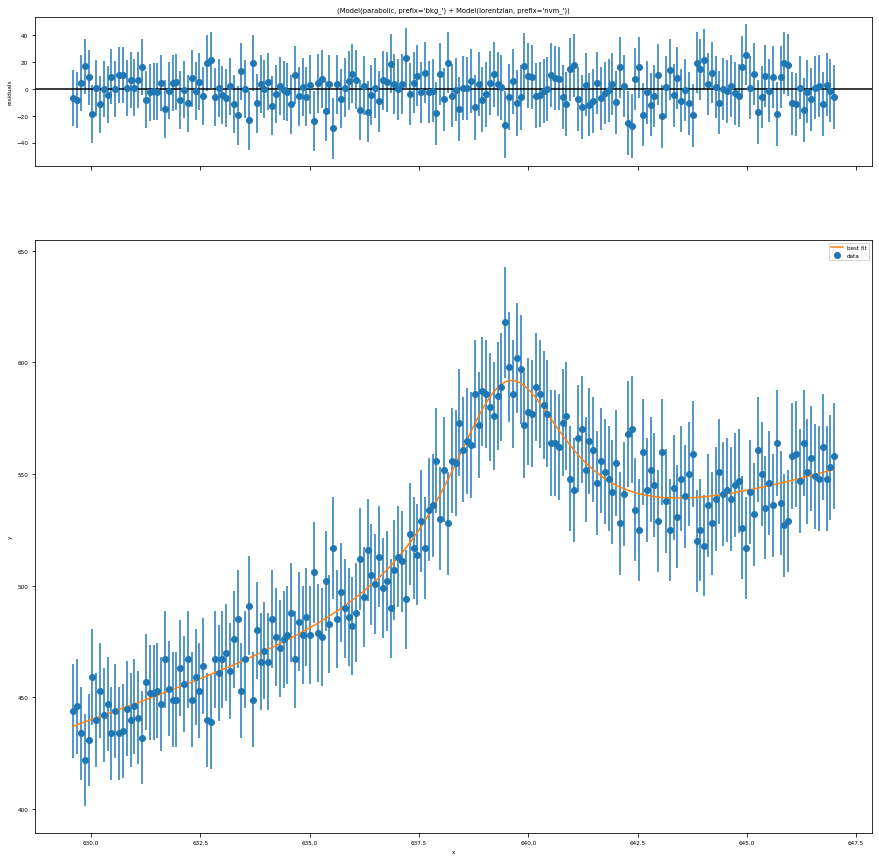

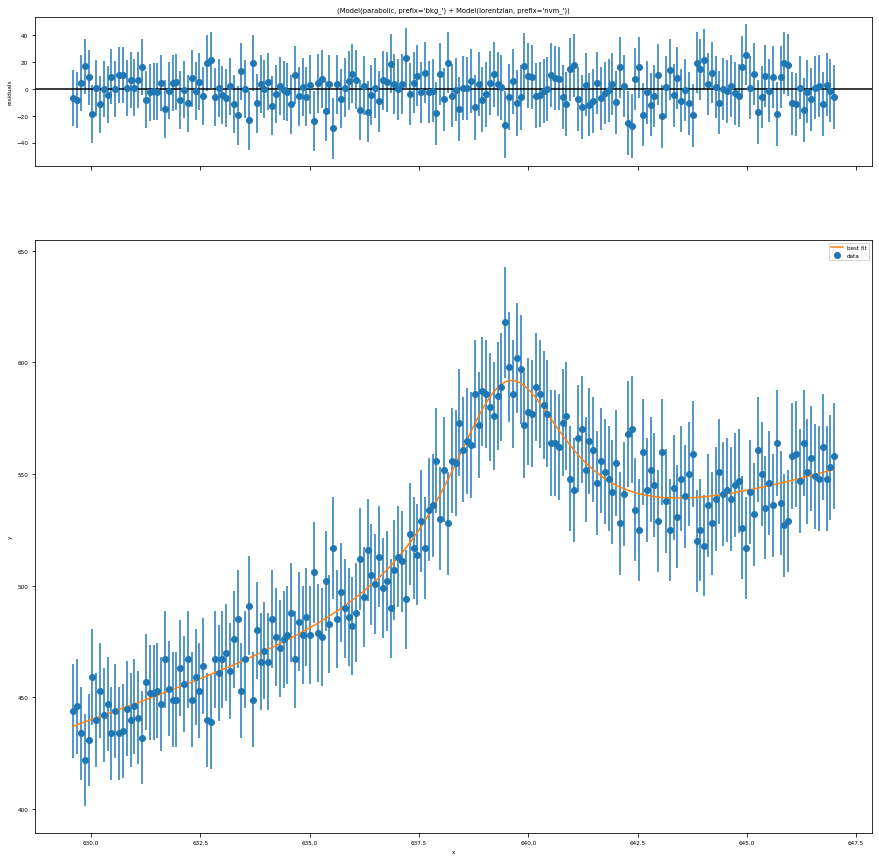

In [61]:
Index = list(range(910,1110))

weightList = 1/np.sqrt(currentPL[Index])

result = model.fit(currentPL[Index], params, x=wavel[Index], weights=weightList)
print(result.fit_report(show_correl=False))
myfig=plt.figure(figsize=(15,15))
result.plot(fig=myfig)

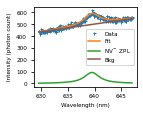

In [62]:
comps = result.eval_components(x=wavel[Index])
plt.rcParams.update({'font.size': 5.67})
cm = 1/2.54
fig = plt.figure(figsize=(5*cm, 4*cm))
plt.ylabel('Intensity (photon count)')
plt.xlabel('Wavelength (nm)')
plt.plot(wavel[Index], currentPL[Index], '+', markersize=3, label='Data')
plt.plot(wavel[Index], result.best_fit, label='Fit')
plt.plot(wavel[Index], comps['nvm_'], label='NV$^-$ ZPL')
plt.plot(wavel[Index], comps['bkg_'], color = 'C5',label='Bkg')
plt.legend()
plt.tight_layout()

fig.savefig('NV ZPL fit.pdf', format= 'pdf',transparent=True)

In [63]:
def integrate (wavelength, intensity, minWavelength, maxWavelength):
    sum = 0
    Index = list(range(findarg(wavelength, minWavelength),findarg(wavelength, maxWavelength)))
    for i in Index:
        sum += intensity[i]*(wavelength[i+1]-wavelength[i])
    return sum

In [64]:
nvmCenter = result.params['nvm_center']
nvmHWHM = result.params['nvm_sigma']

In [65]:
integrate(wavel[Index],comps['nvm_'],nvmCenter - nvmHWHM*2, nvmCenter + nvmHWHM*2)

358.9480304595436